### Setting stuff up

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/cryptooo/notebooks

/content/drive/MyDrive/cryptooo/notebooks


In [ ]:
!pip install -r requirements.txt

In [ ]:
# Loading in code from crypto_tools
import json
from itertools import chain

foo=json.load(open("/content/drive/MyDrive/cryptooo/notebooks/crypto_tools"))
toolstr=''.join(chain(*[tmp['source'] for tmp in foo['cells'] if tmp['cell_type']=='code']))
exec(toolstr)

Connected to the CoinBase Pro API.
Found 242 instances containing the term USD.
Extended Output is False, returning reduced dataset.


2022-02-14 18:51:36.311 | INFO     | __main__:<module>:54 - Created pbtc and dbtc
2022-02-14 18:51:37.405 | INFO     | __main__:<module>:54 - Created peth and deth
2022-02-14 18:51:38.576 | INFO     | __main__:<module>:54 - Created pltc and dltc


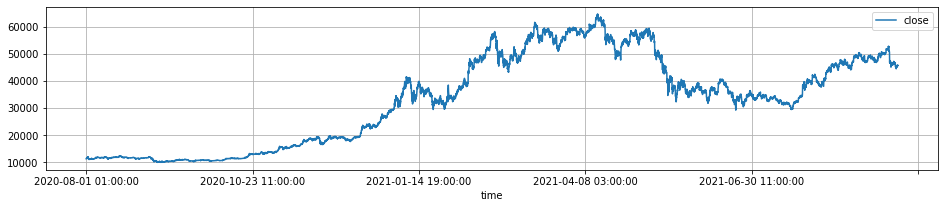

In [ ]:
pl.figure(figsize=(16,3))
pbtc.plot(y='close',x="time",ax=pl.gca())
pl.gca().grid(True)
display(pl.gca())

### Exploratory models

##### Local setup

In [ ]:
from pyspark.ml.linalg import Vectors,Vectors,VectorUDT
from pyspark.ml.regression import LinearRegression,LinearRegressionModel
from pyspark.sql.types  import StringType
import datetime as dt
import pylab as pl

to_vec=F.udf(lambda x:Vectors.dense(x),VectorUDT())

def ar_traindat(indf,win_len=10,feat_col="features",pred_col="open"):

  x=(indf.withColumn(feat_col,F.collect_list(pred_col)
  .over(Window.orderBy("time").rowsBetween(-win_len,-1)))
  .where(f"cardinality({feat_col})={win_len}")
  .withColumn(feat_col,to_vec(feat_col))
  .alias("dbtc").selectExpr("dbtc.*",f"{pred_col} as label"))

  return x

def addHour(timestr,hrs):

  fmtstr="%Y-%m-%d %H:%M:%S"
  return dt.datetime.strftime(dt.datetime.strptime(timestr,fmtstr)+dt.timedelta(hours=hrs),fmtstr)

addHour_udf = F.udf(lambda x,hrs:addHour(x,hrs),StringType())

def get_xpred(lrmod,xtest,safety_margin=0.02):
  xpred=(lrmod.transform(xtest)
  .join(xtest.selectExpr("time","open as open_next").
        withColumn("time",addHour_udf("time",F.lit(-1))),"time")
  .withColumn("return",F.when(F.expr(f"prediction<(open*{1-safety_margin})"),F.expr("open_next-open"))
  .when(F.expr(f"prediction>(open*{1+safety_margin})"),F.expr("open-open_next")).otherwise(F.lit(0))))

  return xpred

##### BTC Model

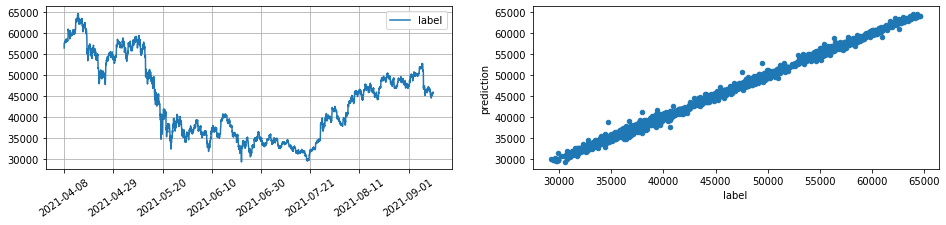

In [ ]:
#@title Training

x=(ar_traindat(dbtc,10)#.select("features","label","time")
.withColumn('cnt',F.rank().over(Window.orderBy("time"))))

xtrain=x.where("cnt<6000")
xtest=x.where("cnt>=6000")

btc_lrmod=LinearRegression().fit(xtrain)

# Sanity check
pl.figure(figsize=(16,3))

pl.subplot(1,2,1)
xtest.toPandas().plot(x='time',y='label',rot=35,ax=pl.gca())
ax=pl.gca()
ax.grid(True)
ax.set_xlabel('')
ax.set_xticklabels([tmp.get_text()[:10] for tmp in ax.get_xticklabels()])

pl.subplot(1,2,2)
btc_lrmod.transform(xtest).select("label","prediction").toPandas().plot(x='label',y='prediction',kind='scatter',ax=pl.gca())

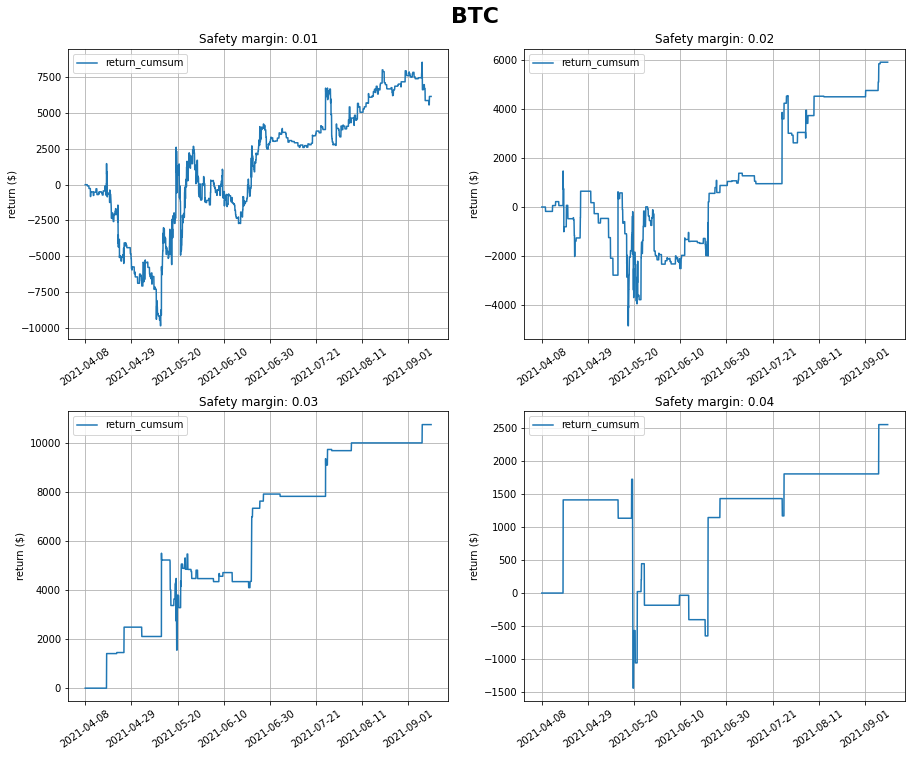

In [ ]:
#@title Backtesting

safety_margins=[.01,.02,.03,.04]
xpreds=[get_xpred(btc_lrmod,xtest,safety_margin=tmp) for tmp in 
        safety_margins]

pl.figure(figsize=(15,12))
axmain=pl.gca()
pl.subplots_adjust(hspace=.25)

# Visualization

for count in range(4):

  pf=(xpreds[count].select("time","open","return").
      toPandas().iloc[1:,:])
  pf['return_cumsum']=pf['return'].cumsum()

  pl.subplot(2,2,count+1)
  pf.plot(x="time",y="return_cumsum",rot=35, ax=pl.gca())
  pl.title(f"Safety margin: {safety_margins[count]}")
  
  ax=pl.gca()
  ax.grid(True)
  foo=ax.set_xticklabels([tmp.get_text()[:10] for tmp in ax.get_xticklabels()])
  ax.set_xlabel('')
  ax.set_ylabel("return ($)")

foo=pl.gcf().text(0.48,.91,'BTC',
                  fontsize=22,fontweight='bold')

##### ETH Model

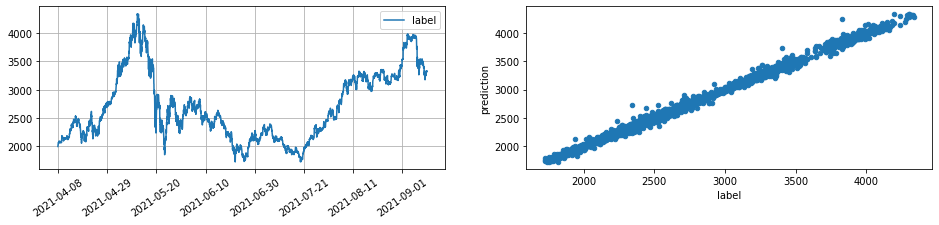

In [ ]:
#@title Training

x=(ar_traindat(deth,10)#.select("features","label","time")
.withColumn('cnt',F.rank().over(Window.orderBy("time"))))

xtrain=x.where("cnt<6000")
xtest=x.where("cnt>=6000")

eth_lrmod=LinearRegression().fit(xtrain)

# Sanity check
pl.figure(figsize=(16,3))

pl.subplot(1,2,1)
xtest.toPandas().plot(x='time',y='label',rot=35,ax=pl.gca())
ax=pl.gca()
ax.grid(True)
ax.set_xlabel('')
ax.set_xticklabels([tmp.get_text()[:10] for tmp in ax.get_xticklabels()])

pl.subplot(1,2,2)
eth_lrmod.transform(xtest).select("label","prediction").toPandas().plot(x='label',y='prediction',kind='scatter',ax=pl.gca())

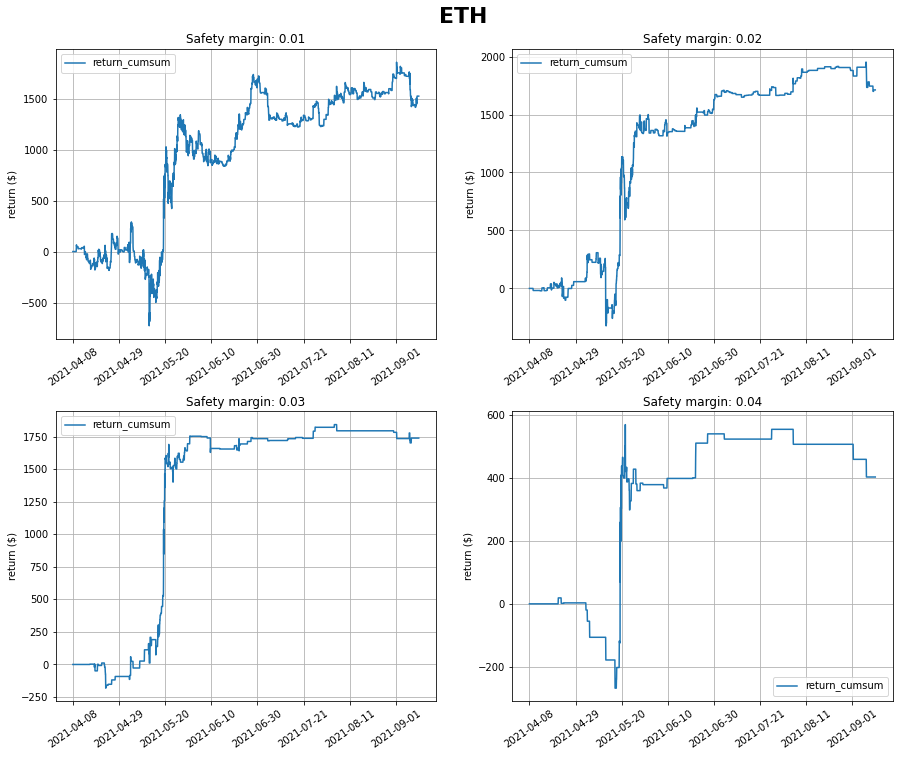

In [ ]:
#@title Backtesting

safety_margins=[.01,.02,.03,.04]
xpreds=[get_xpred(eth_lrmod,xtest,safety_margin=tmp) for tmp in 
        safety_margins]

pl.figure(figsize=(15,12))
pl.subplots_adjust(hspace=.25)

# Visualization

for count in range(4):

  pf=xpreds[count].select("time","open","return").toPandas().iloc[1:,:]
  pf['return_cumsum']=pf['return'].cumsum()

  pl.subplot(2,2,count+1)
  pf.plot(x="time",y="return_cumsum",rot=35, ax=pl.gca())
  pl.title(f"Safety margin: {safety_margins[count]}")
  
  ax=pl.gca()
  ax.grid(True)
  foo=ax.set_xticklabels([tmp.get_text()[:10] for tmp in ax.get_xticklabels()])
  ax.set_xlabel('')
  ax.set_ylabel("return ($)")

foo=pl.gcf().text(0.48,.91,'ETH',
                  fontsize=22,fontweight='bold')

##### LTC Model

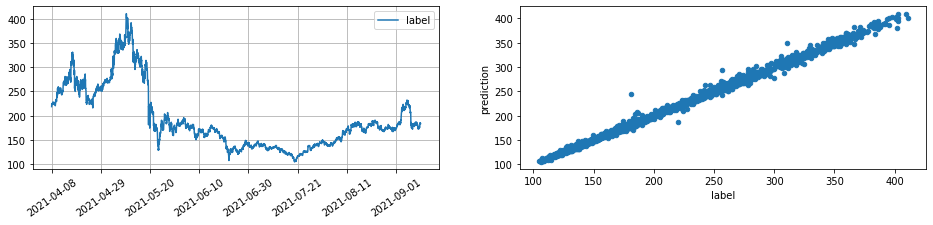

In [ ]:
#@title Training

x=(ar_traindat(dltc,10)#.select("features","label","time")
.withColumn('cnt',F.rank().over(Window.orderBy("time"))))

xtrain=x.where("cnt<6000")
xtest=x.where("cnt>=6000")

ltc_lrmod=LinearRegression().fit(xtrain)

# Sanity check
pl.figure(figsize=(16,3))

pl.subplot(1,2,1)
xtest.toPandas().plot(x='time',y='label',rot=35,ax=pl.gca())
ax=pl.gca()
ax.grid(True)
ax.set_xlabel('')
ax.set_xticklabels([tmp.get_text()[:10] for tmp in ax.get_xticklabels()])

pl.subplot(1,2,2)
ltc_lrmod.transform(xtest).select("label","prediction").toPandas().plot(x='label',y='prediction',kind='scatter',ax=pl.gca())

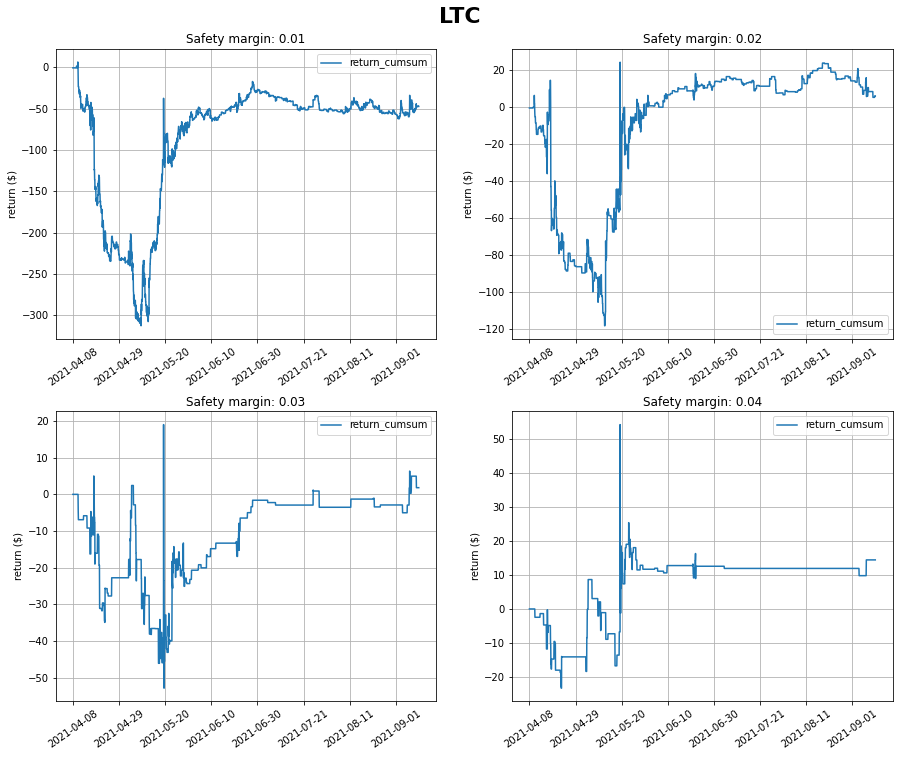

In [ ]:
#@title Backtesting

safety_margins=[.01,.02,.03,.04]
xpreds=[get_xpred(ltc_lrmod,xtest,safety_margin=tmp) for tmp in 
        safety_margins]

pl.figure(figsize=(15,12))
pl.subplots_adjust(hspace=.25)

# Visualization

for count in range(4):

  pf=xpreds[count].select("time","open","return").toPandas().iloc[1:,:]
  pf['return_cumsum']=pf['return'].cumsum()

  pl.subplot(2,2,count+1)
  pf.plot(x="time",y="return_cumsum",rot=35, ax=pl.gca())
  pl.title(f"Safety margin: {safety_margins[count]}")
  
  ax=pl.gca()
  ax.grid(True)
  foo=ax.set_xticklabels([tmp.get_text()[:10] for tmp in ax.get_xticklabels()])
  ax.set_xlabel('')
  ax.set_ylabel("return ($)")

foo=pl.gcf().text(0.48,.91,'LTC',
                  fontsize=22,fontweight='bold')